# Exploratory Data Analysis

In the following notebook... 

## Preliminaries

### Import Libraries

In [1]:
# data/math libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [122]:
# create folder path where data lives
from pathlib import Path
import pickle
data_folder = Path('C:/Users/Kathleen Lange/MSDS692_Practicum_I')

In [3]:
# import data from csv files
df_train = pd.read_csv(data_folder / 'plasticc_data/training_set.csv')
df_train_meta = pd.read_csv(data_folder / 'plasticc_data/training_set_metadata.csv')

In [4]:
# look at training dataframe structure
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421705 entries, 0 to 1421704
Data columns (total 6 columns):
object_id    1421705 non-null int64
mjd          1421705 non-null float64
passband     1421705 non-null int64
flux         1421705 non-null float64
flux_err     1421705 non-null float64
detected     1421705 non-null int64
dtypes: float64(3), int64(3)
memory usage: 65.1 MB
None


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [5]:
# look at training metadata dataframe structure
print(df_train_meta.info())
df_train_meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Data columns (total 12 columns):
object_id             7848 non-null int64
ra                    7848 non-null float64
decl                  7848 non-null float64
gal_l                 7848 non-null float64
gal_b                 7848 non-null float64
ddf                   7848 non-null int64
hostgal_specz         7848 non-null float64
hostgal_photoz        7848 non-null float64
hostgal_photoz_err    7848 non-null float64
distmod               5523 non-null float64
mwebv                 7848 non-null float64
target                7848 non-null int64
dtypes: float64(9), int64(3)
memory usage: 735.8 KB
None


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


## Review and Clean Data

Only one column from the metadata file has NaNs. Check to see if all of the distmod NaN values correspond to a redshift of zero. The distmod should be zero because the objects are within the Milky Way. I can replace the NaNs with zeroes if this is the case.

In [6]:
df_train_meta['hostgal_photoz'].loc[df_train_meta['distmod'].isnull()].sum()

0.0

In [7]:
# replace NaNs with zeroes.
df_train_meta.fillna(0, inplace=True)

In [10]:
# check to see all of the unique objects in the training file are accounted for in the metadata file.
print(df_train['object_id'].nunique())
print(len(df_train_meta))

7848
7848


In [12]:
# check to see if the detected values are the same for every object, or if they change
df_train.groupby('object_id')['detected'].value_counts().head(n=15)

object_id  detected
615        1           333
           0            19
713        0           290
           1            60
730        0           307
           1            23
745        0           290
           1            61
1124       0           291
           1            61
1227       0           327
           1             3
1598       0           332
           1            20
1632       0           349
Name: detected, dtype: int64

From the organizer's dataset description, the detected value is related to the ratio of flux to the flux error. However, it also has to do with the ambient light conditions (i.e. moon, clouds, dust) so it is not a simple ratio of the two values. Therefore, it makes sense that objects have observations that are categorized both as detected as true and false. This may be one way to train the model and predict the testing set by only taking values where detected = 1.

In [ ]:
# use this to change the time variable from a float value to a datetime value if needed
# from astropy.time import Time
# df_train['mjd'] = Time(df_train['mjd'], format='mjd')

Another way to sort the data would be by galactic vs. extragalactic objects to help simplify the machine learning.

In [13]:
# make a new categorical variable for gal/ex_gal objects based on the redshift value of 0
df_train_meta['origin'] = df_train_meta['hostgal_photoz'].apply(lambda x: 'galactic' if x == 0.0 else 'extragalactic')
df_train_meta['origin'] = df_train_meta['origin'].astype('category')

## Visualize Meta Data

In [17]:
# count the number of objects per each target by gal/ex_gal variable
pd.DataFrame(df_train_meta.groupby('origin')['target'].value_counts())

target
origin        target        
extragalactic 90        2313
              42        1193
              15         495
              62         484
              88         370
              67         208
              52         183
              95         175
              64         102
galactic      65         981
              16         924
              92         239
              6          151
              53          30

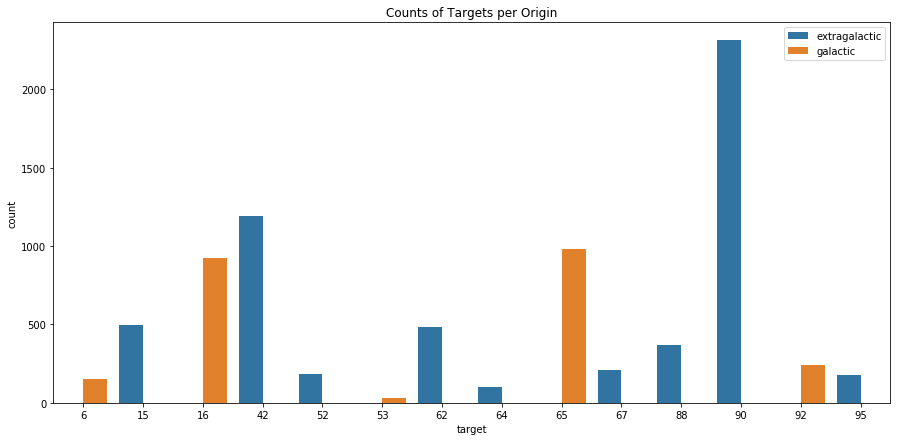

In [16]:
# visualize the above grouping
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.countplot(df_train_meta.target, hue=df_train_meta.origin)
ax.set_title('Counts of Targets per Origin')
ax.legend()
plt.show()

The above plot shows that for each target, astronomical object type, they are only galactic or extragalactic. Targets are distinct based on if they are within the Milky Way, or outside of the galaxy. Because these variables are completely separate, it would be a good choice to use if needed to simplify the datasets for the machine learning methods. I could train the algorithm on either the galactic or extra-galactic datasets and see how the accuracy changes or which parameters are most important to use to optimize the algorithm.

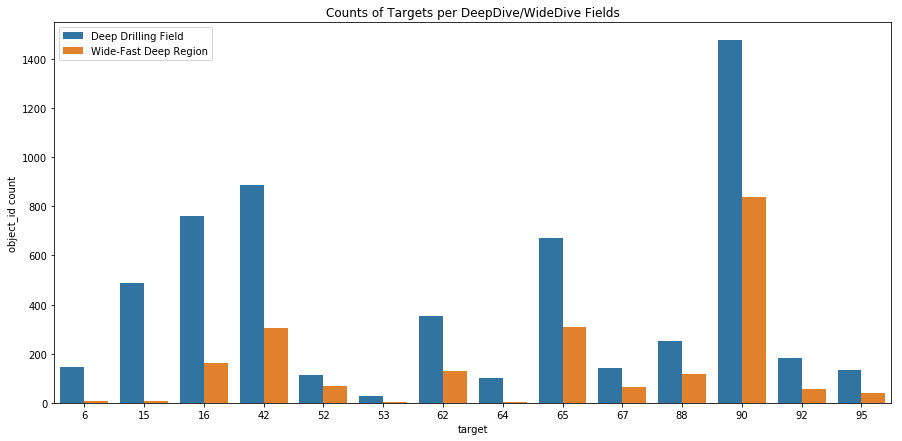

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.countplot(df_train_meta.target, hue=df_train_meta.ddf)
ax.legend(['Deep Drilling Field', 'Wide-Fast Deep Region'])
ax.set_title('Counts of Targets per DeepDive/WideDive Fields')
ax.set_ylabel('object_id count')
plt.show()

Both the deep drilling fields and the wide-fast regions contain each type target. There are obviously more observations per target for the deep drilling fields. These may contribute to creating more detailed light curves and therefore a more accurate reconstruction of the period or phase of oscillation if applicable. If the period/phase is determined to be a critical feature fot the machine learning algorithm, I may decide to subset the training and testing datasets to only include the ddf = 1 variable.

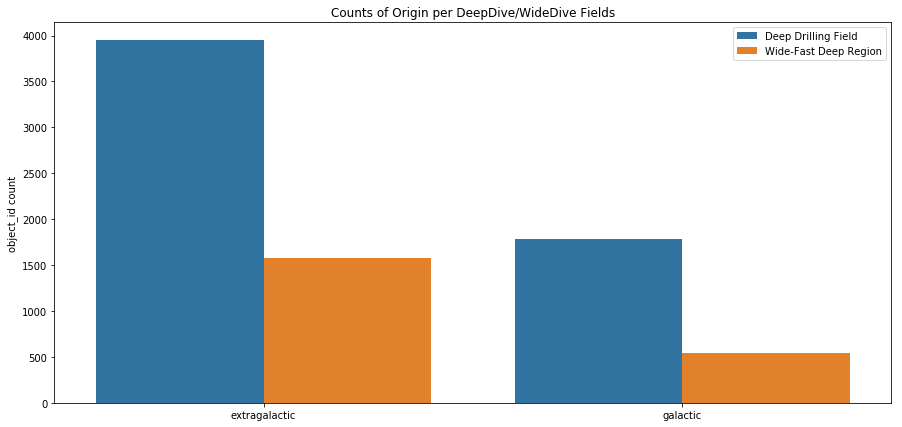

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.countplot(df_train_meta.origin, hue=df_train_meta.ddf)
ax.legend(['Deep Drilling Field', 'Wide-Fast Deep Region'])
ax.set_xlabel(None)
ax.set_ylabel('object_id count')
ax.set_title('Counts of Origin per DeepDive/WideDive Fields')
plt.show()

The deep drilling fields have more objects for both the extragalactic and galactic objects. The above plot does not add any further details about the dataset or how it should be subset if needed.

One way to understand the distribution of the astronomical objects is to look at their redshift values. Are certain targets located closer to the Milky Way, while other are very far off? This could be one way to determine what type of astronomical object it is. Also, objects further away may have smaller flux values because of their distance.

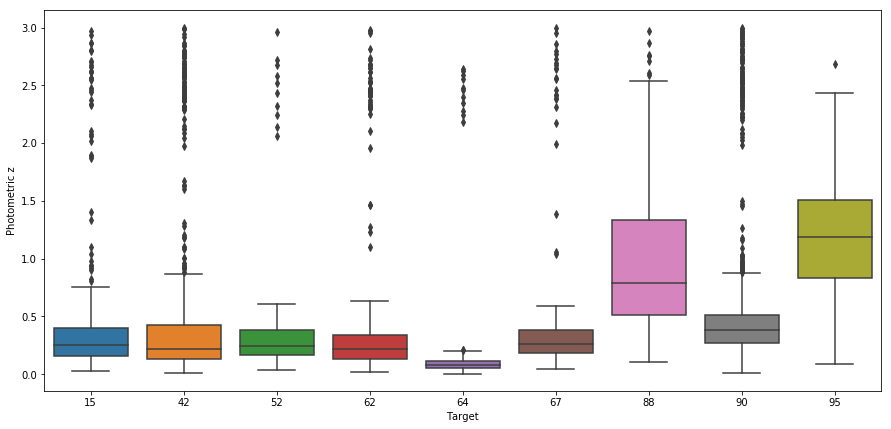

In [32]:
# create subset of only the extragalactic objects
ex_gal = df_train_meta.loc[df_train_meta.origin == 'extragalactic'] 
fig, ax = plt.subplots(figsize=(15,7), sharex=True)
sns.boxplot(x=ex_gal.target, y=ex_gal.hostgal_photoz, ax=ax)
ax.set_xlabel('Target')
ax.set_ylabel('Photometric z')
plt.show()

Overall, the first 4 objects on the chart are roughly located about the same distance away from the Milky Way because their boxplots are very comparable. However, target 64 seems to be on average closer to the Milky Way, while targets 88 and 95 seem to be on average further away from the Milky Way. That could indicate that these are maybe more quasar-like objects.

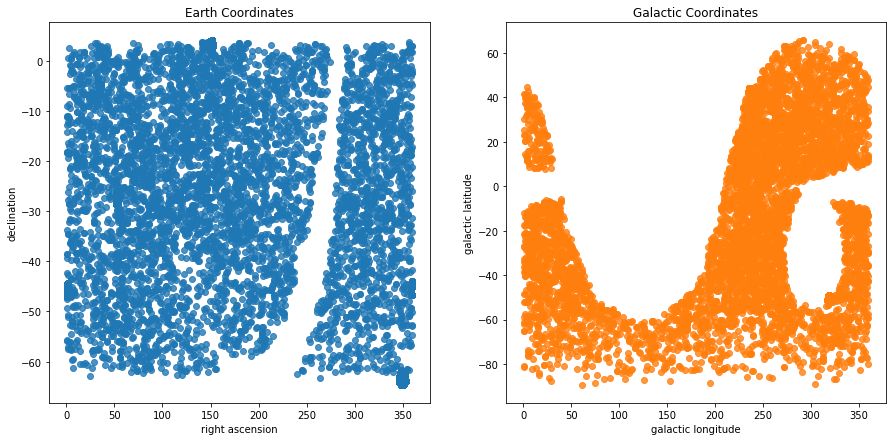

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,7))

g1 = sns.regplot(x='ra', 
                 y ='decl', 
                 data=df_train_meta, 
                 fit_reg=False,    
                 ax = ax1)
g1.set_xlabel("right ascension")
g1.set_ylabel("declination")
g1.set_title("Earth Coordinates", fontsize=12)

g2 = sns.regplot(x = 'gal_l',
                 y = 'gal_b', 
                 data = df_train_meta,
                 fit_reg = False, 
                 ax = ax2)
g2.set_title('gal')
g2.set_xlabel("galactic longitude")
g2.set_ylabel("galactic latitude")
g2.set_title("Galactic Coordinates", fontsize=12)

plt.show()

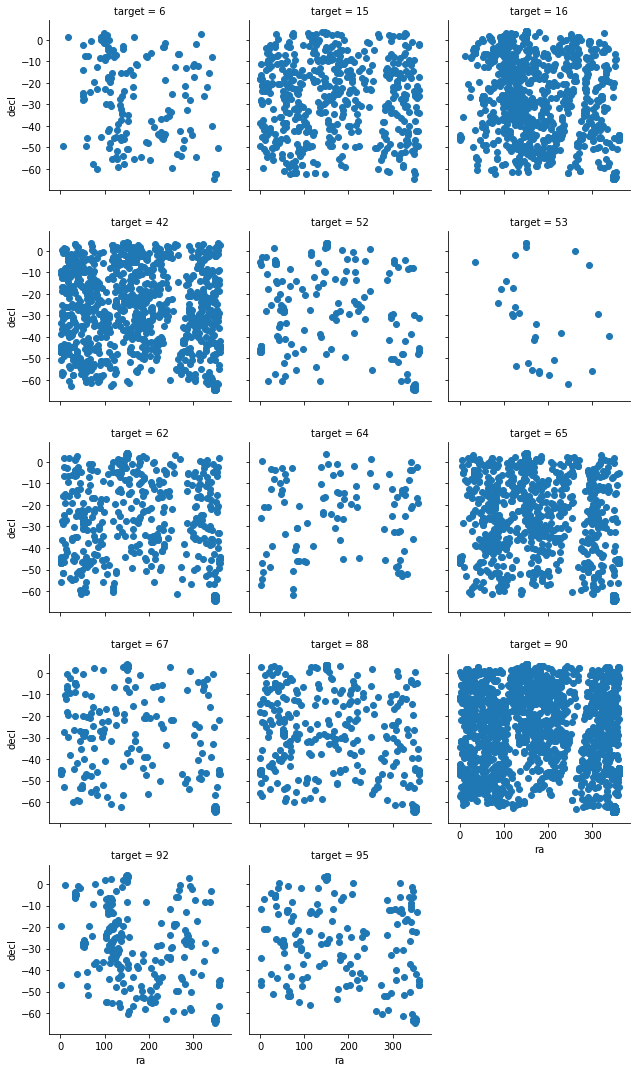

In [62]:
g = sns.FacetGrid(df_train_meta, 
                  col="target", 
                  col_wrap=3, 
                  height=3)
g = g.map(plt.scatter, 
          'ra', 
          'decl', 
          marker="o")

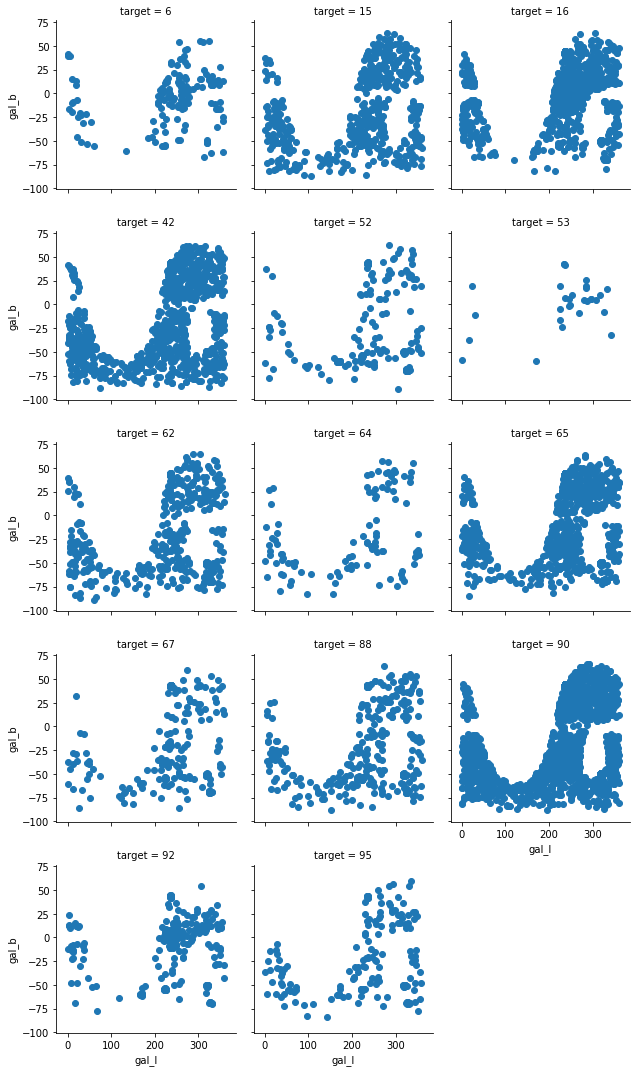

In [63]:
g = sns.FacetGrid(df_train_meta, 
                  col="target", 
                  col_wrap=3, 
                  height=3)
g = g.map(plt.scatter, 
          'gal_l', 
          'gal_b', 
          marker="o")

The above plots show the distribution across the sky of all of the objects and then with each type of object split out. It shows that there is no preferred direction in the sky for a specific type of object. In both the galactic and Earth reference frames, each target is fairly evenly distributed throughout the sky. Therefore, there is not much information to be gained using the coordinates as features in the machine learning models.

In [128]:
df_train_meta.drop(columns=['ra', 'decl', 'gal_l', 'gal_b'], inplace=True)

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,origin
0,615,1,0.0000,0.0000,0.0000,0.0000,0.017,92,galactic
1,713,1,1.8181,1.6267,0.2552,45.4063,0.007,88,extragalactic
2,730,1,0.2320,0.2262,0.0157,40.2561,0.021,42,extragalactic
3,745,1,0.3037,0.2813,1.1523,40.7951,0.007,90,extragalactic
4,1124,1,0.1934,0.2415,0.0176,40.4166,0.024,90,extragalactic


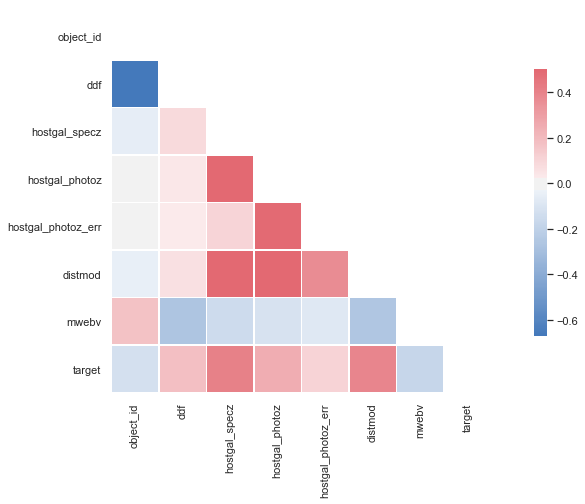

In [129]:
# following code copied from seaborn documentation example: 
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

corr = df_train_meta.corr()

mask = np.zeros_like(corr, dtype=np.bool) # white upper triangle mask
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 7))

cmap = sns.diverging_palette(250, 10, as_cmap=True) # custom colormap

g = sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.5, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .7})


The above heatmap shows that the most correlated features are the two redshift measurements along with the distance measurement. This is as expected because the z values are just being measured in two different methods although they are measuring the same thing. The distmod value is a directly calculated value using the photo_z measurement. One thing of interest might be that the error in photo_z is directly correlated to the photo_z measurement. So as z is getting larger, so is the error in the measurement. One way to normalize the flux values might be to divide the them by some one of the redshift or distance measurements. If using the photo_z value, then this will have to be weighted by the error in it as well.

## Visualize Example Training Data

The following few lines of code pick out examples of each type of object and plot their light curves.

In [73]:
# create list of unique target values
classes = df_train_meta.target.unique().tolist()
classes.sort()

# pick out a few example object_ids related to each target value (performed this by hand)
class_exs = [18556, 4173, 2677, 730, 10757, 133773, 3910, 62187, 1227, 2922, 713, 2072, 615, 3423]

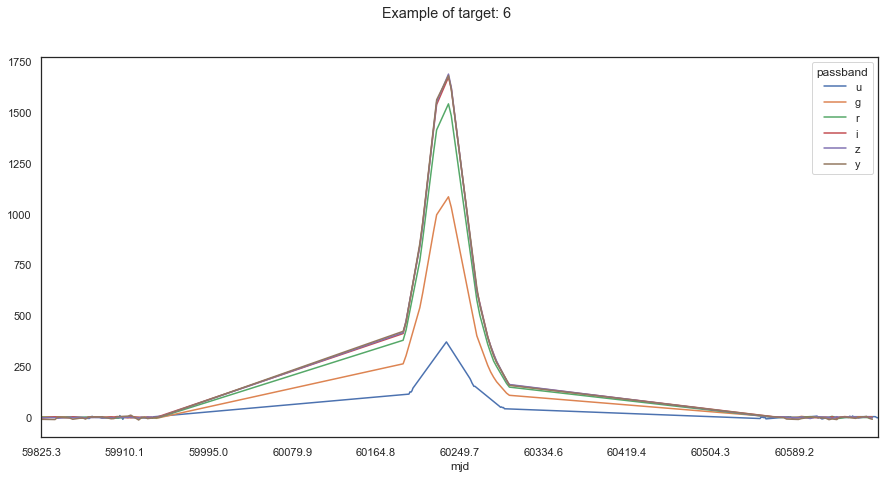

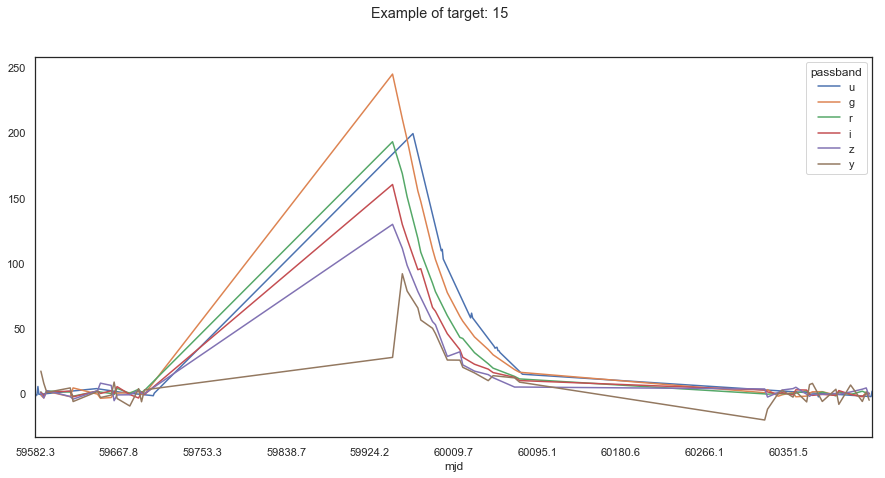

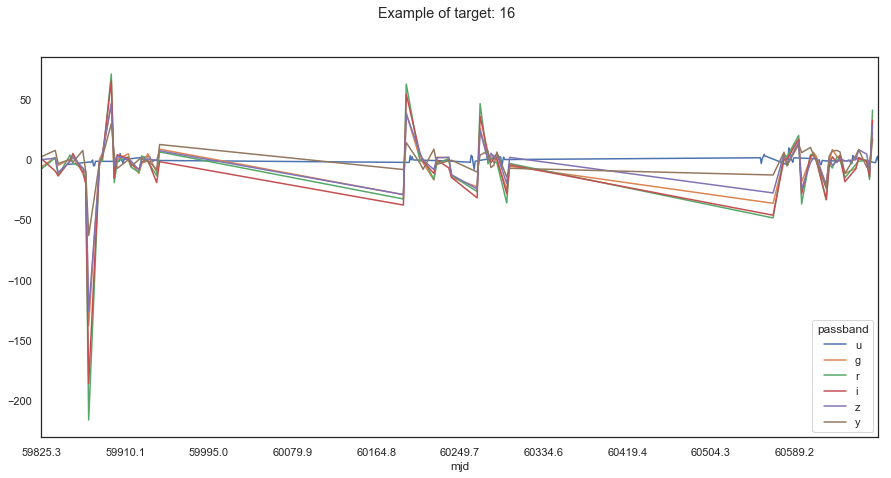

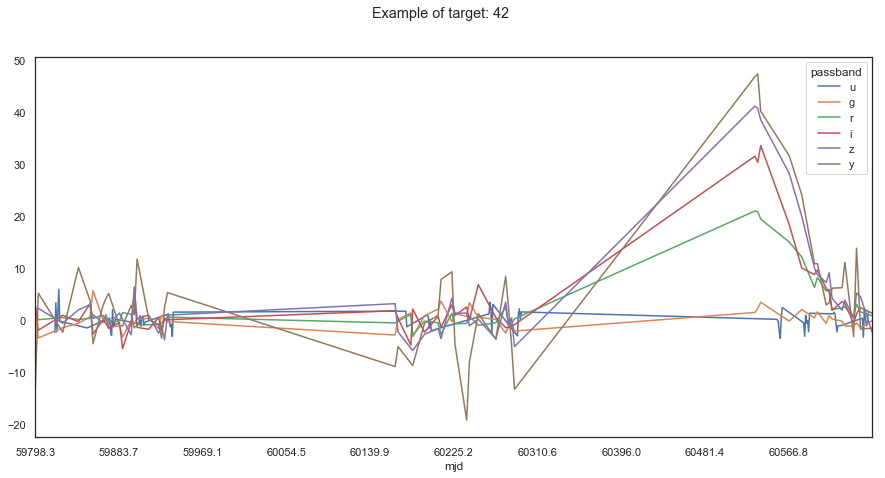

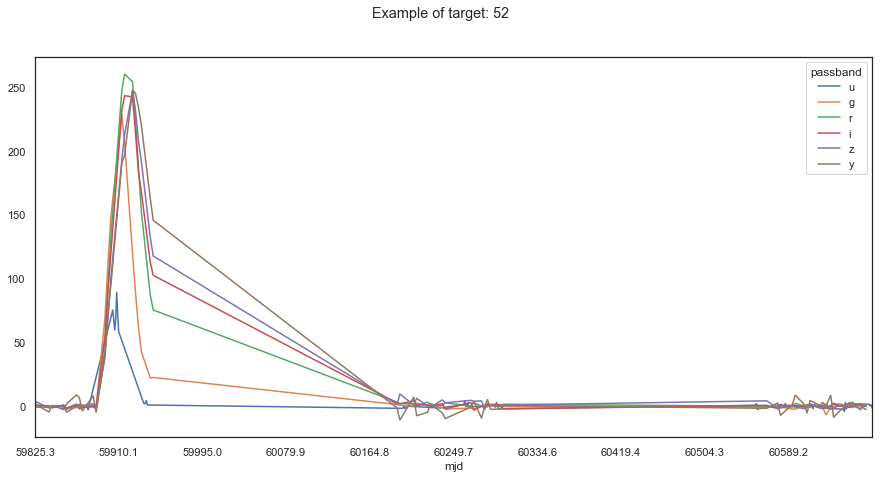

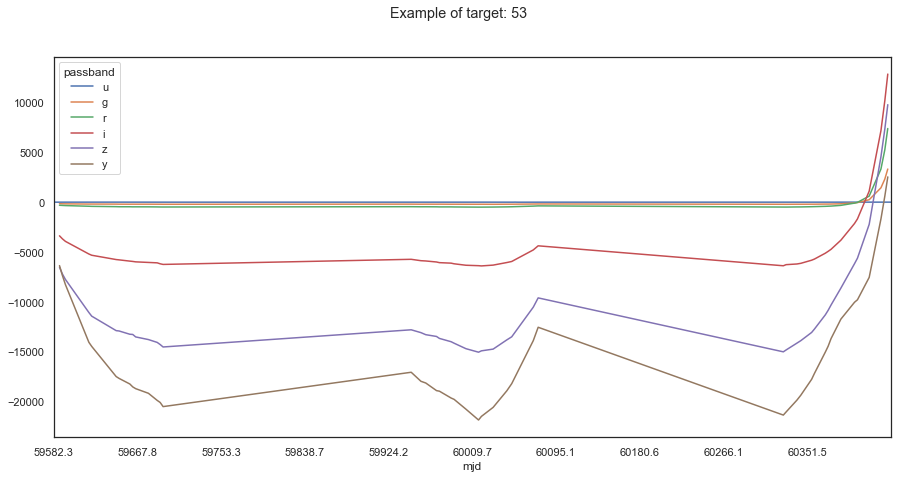

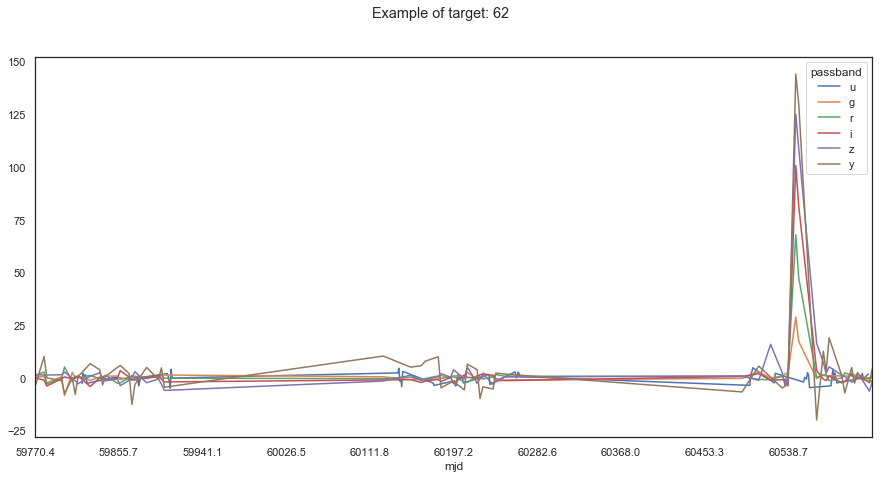

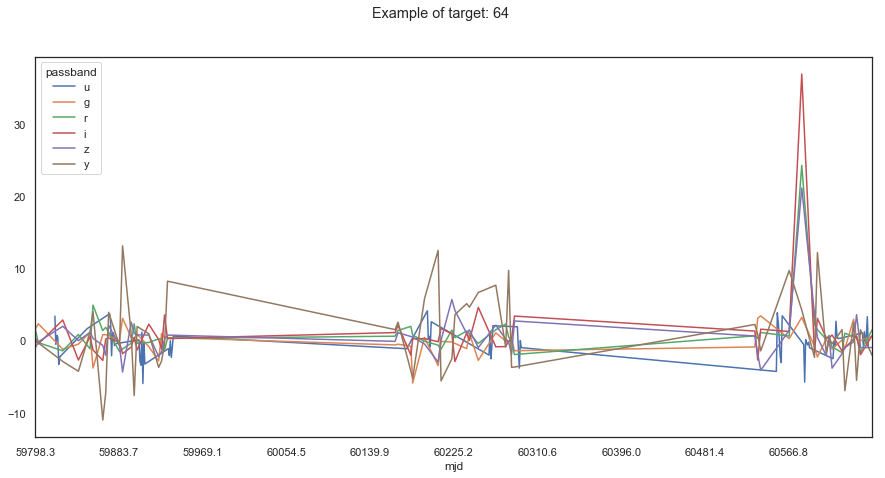

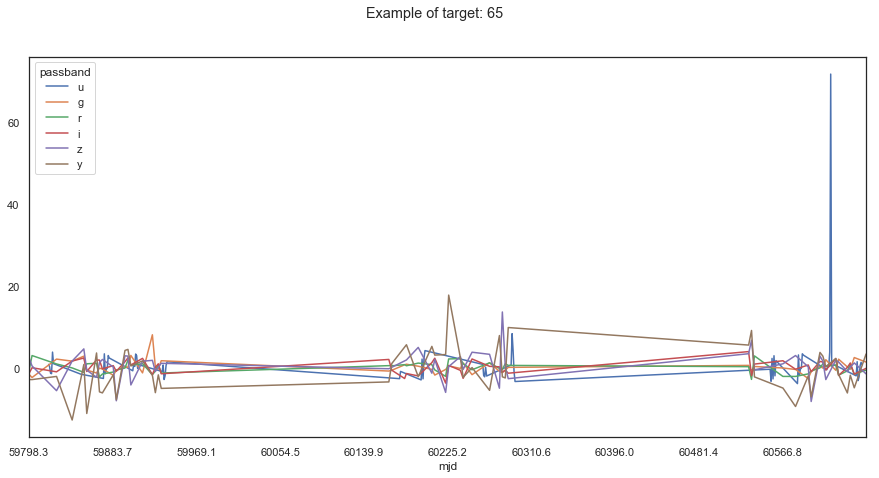

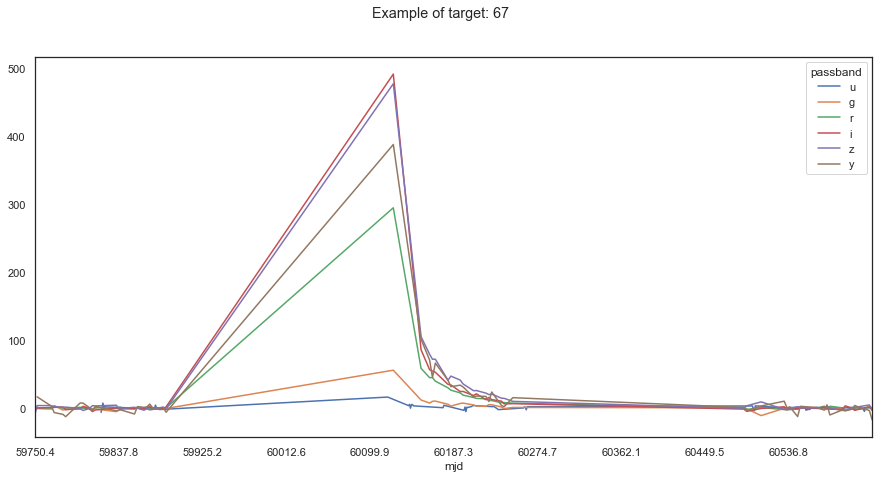

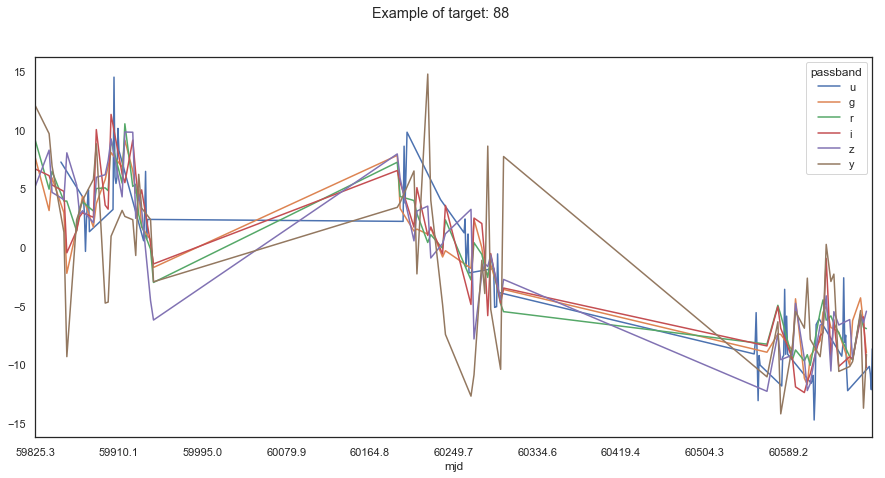

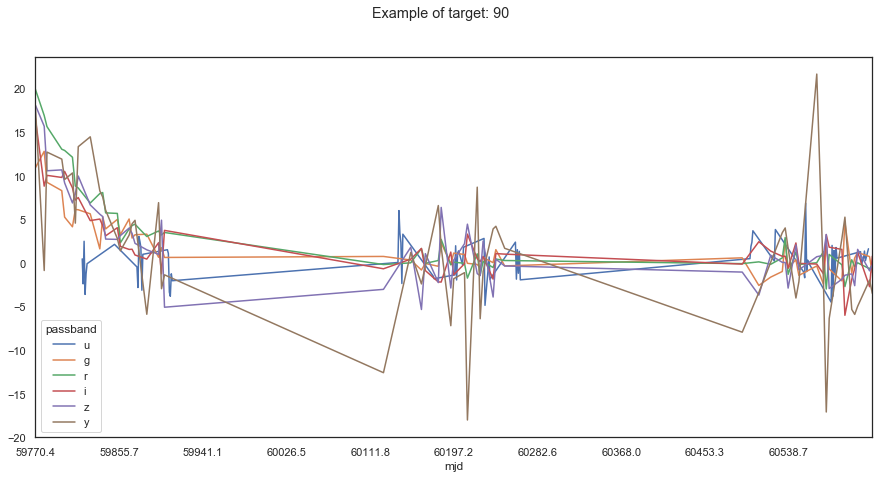

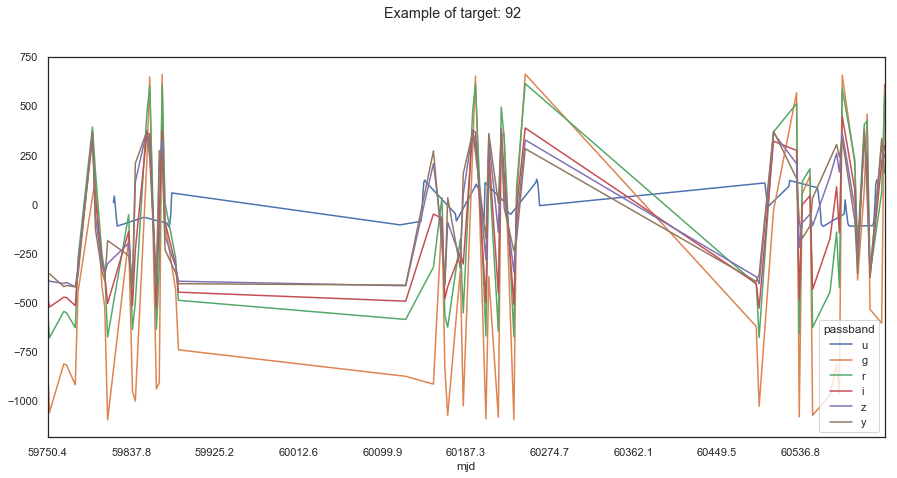

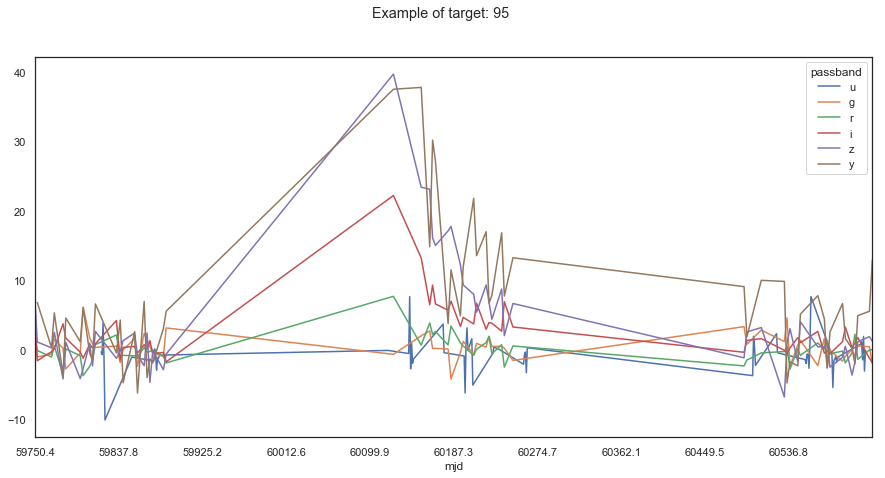

In [87]:
# plot light curve for each of the example object_ids above
pbnames = ['u','g','r','i','z','y']
for n in range(len(class_exs)):
    df_n = df_train.loc[df_train['object_id'] == class_exs[n]]
    ticks = np.arange(df_n.mjd.min(), df_n.mjd.max(), (df_n.mjd.max() - df_n.mjd.min())/10)
    df_n.set_index('mjd', inplace=True)
    fig = df_n.groupby('passband')['flux'].plot(legend=True, figsize=(15,7), xticks=ticks)
    title = 'Example of target: ' + str(classes[n])
    plt.suptitle(title)
    plt.legend(pbnames, title='passband')
    plt.show()

The above plots show that some objects have obvious periodic behavior (targets 88, 90, 92), while others seem to be more like burst events (targets 6, 15, 52). Also, some objects have a burst behavior mixed in with one of the periods (targets 95, 64). There are also a few instances where certain passbands show different behavior from the others like they are delayed or have bursts while the other passbands do not. Using features based on each of the different passbands could prove useful in the ML algorithm.

To analyze the time series features of the training data the following four graphs came from Mithrillion's kaggle kernel ["Strategies for Flux Time Series Preprocessing"](https://www.kaggle.com/mithrillion/strategies-for-flux-time-series-preprocessing).

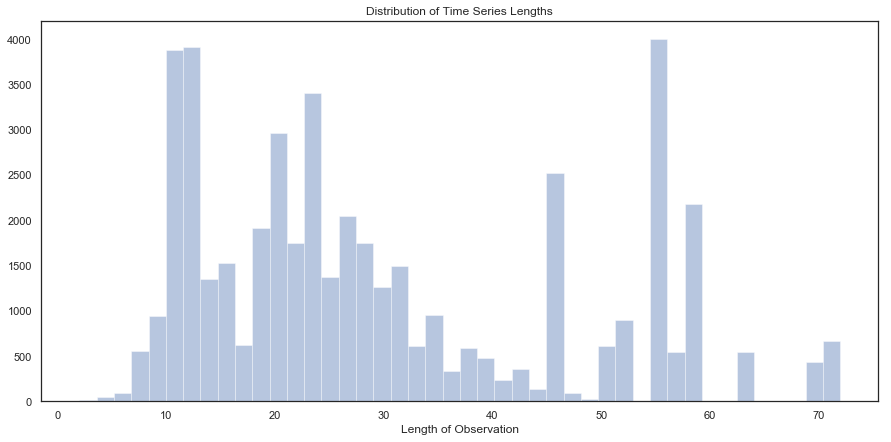

In [100]:
ts_lens = df_train.groupby(['object_id', 'passband']).size() # find the length of each of the objects per passband
# length of observation is related to the time of the observation, but because of the differences if when each
# object is observed using mjd.max - mjd.min does not work for this graph.

f, ax = plt.subplots(figsize=(15, 7))
sns.distplot(ts_lens, kde=False, ax=ax) 
ax.set_title('Distribution of Time Series Lengths')
ax.set_xlabel('Length of Observation') 
plt.show()

Some objects are observed for much longer than other objects are. This is obvious from the fact that there are deep-driling fields identified, but also, it looks like there a difference in the amount of time that even objects within the DDFs are observed. Most machine learning algorithms doing time-series analysis require a consistent time variable; a variable that is of equal total lengths for all observations.

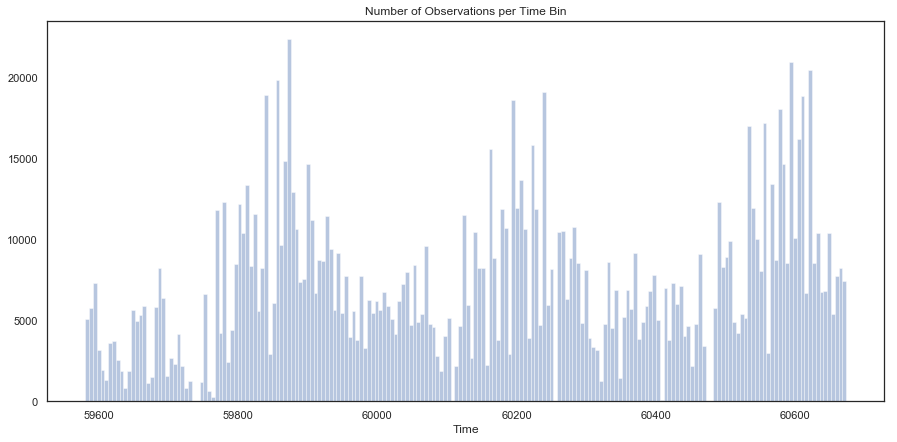

In [103]:
f, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_train['mjd'], kde=False, ax=ax, bins=200)
ax.set_title('Number of Observations per Time Bin')
ax.set_xlabel('Time')
plt.show()

To further demonstrate the point that the time periods are not consistent/equal/sequential, the above plot shows that for each time period (time bin) there are a large range of number of observations occuring. This could be due to sky conditions during the observation related to moonlight, clouds, dust, etc. The above chart seems sort of cyclic and could be related to the time of the year where the observatory is located. Below, the above graph is re-created for a single object and then again for the same object for a single passband. Both confirm that for every object and for every passband the time distribution of observations is very irregular.

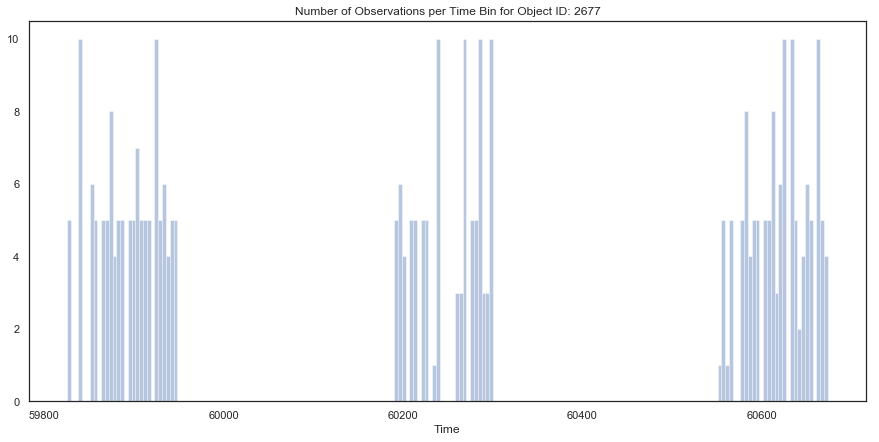

In [114]:
f, ax = plt.subplots(figsize=(15, 7))
n=2
sns.distplot(df_train[df_train['object_id'] == class_exs[n]]['mjd'], kde=False, ax=ax, bins=200)
title = 'Number of Observations per Time Bin for Object ID: ' + str(class_exs[n])
ax.set_title(title)
ax.set_xlabel('Time')
plt.show()

Again, the time distribution of observations is very inconsistent.

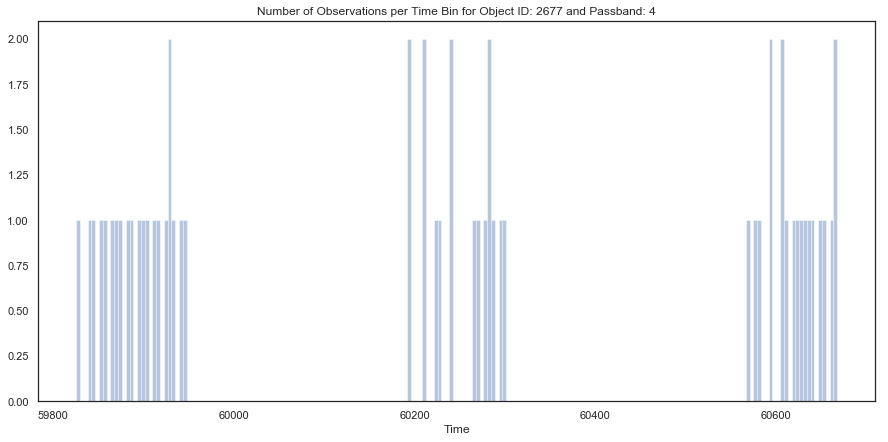

In [121]:
f, ax = plt.subplots(figsize=(15, 7))
n=2
pb=4
sns.distplot(df_train[(df_train['object_id'] == class_exs[n]) & 
                      (df_train['passband'] == pb)]['mjd'], 
             kde=False, 
             ax=ax,
             bins=200)
title = 'Number of Observations per Time Bin for Object ID: ' + str(class_exs[n]) + ' and Passband: ' + str(pb)
ax.set_title(title)
ax.set_xlabel('Time')
plt.show()

From the above observations, it shows that there is a ton of missing data and irregularity within the time-series for each object and even for each passband within a single object. Therefore, using straight mjd as a feature to use in the machine learning algorithm is not going to providet the best results. Therefore, I will not perform a strict time-series classification. I will have to create other features to use in the classification task. Instead of completely ignoring the time-variance of the data, some possible features that could still use the time behavior would be finding the period or phase of oscillation if there is any. Another time-feature may be to find the rise or fall time of the peak.

## Save Cleaned Dataframes

In [130]:
# save training dataframe
with open(data_folder / 'training.pk', 'wb') as f:
    pickle.dump(df_train, f)

# save training metadata datframe
with open(data_folder / 'training_meta.pk', 'wb') as f:
    pickle.dump(df_train_meta, f)